Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6192 - loss: 1.4631 - val_accuracy: 0.7767 - val_loss: 0.8182
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8542 - loss: 0.5780 - val_accuracy: 0.8400 - val_loss: 0.5522
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8992 - loss: 0.3774 - val_accuracy: 0.8633 - val_loss: 0.4783
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9308 - loss: 0.2923 - val_accuracy: 0.9000 - val_loss: 0.4100
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9458 - loss: 0.2368 - val_accuracy: 0.8767 - val_loss: 0.4317
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 45s 1us/step
Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.4550 - loss: 2.9088 - val_accuracy: 0.8067 - val_loss: 0.7322
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - accuracy: 0.9175 - loss: 0.3646 - val_accuracy: 0.9067 - val_loss: 0.3774
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - accuracy: 0.9717 -

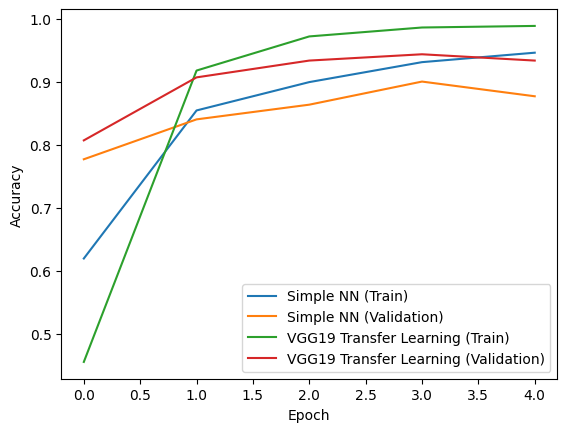

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input

# Load and reduce MNIST dataset for faster training
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:1500]
y_train = y_train[:1500]
X_test = X_test[:500]
y_test = y_test[:500]

# Normalize grayscale data
X_train_froz, X_test_froz = X_train / 255.0, X_test / 255.0
y_train_froz, y_test_froz = to_categorical(y_train), to_categorical(y_test)

# --------------------------
# Baseline Simple NN Model
# --------------------------
model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

hist = model.fit(
    X_train_froz, y_train_froz,
    epochs=5,
    batch_size=64,
    validation_split=0.2
)

# --------------------------
# Transfer Learning with VGG19
# --------------------------
# Convert grayscale to RGB (3 channels)
X_train_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(X_train, axis=-1))
X_test_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(X_test, axis=-1))

# Resize to 224x224 for VGG19
X_train_resized = tf.image.resize(X_train_rgb, (224, 224)) / 255.0
X_test_resized = tf.image.resize(X_test_rgb, (224, 224)) / 255.0

# One-hot encode labels
y_train_rgb = to_categorical(y_train, num_classes=10)
y_test_rgb = to_categorical(y_test, num_classes=10)

# Load pre-trained VGG19 (without top classifier)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classifier on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model_2 = Model(inputs=base_model.input, outputs=output)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train transfer learning model
histo = model_2.fit(
    X_train_resized, y_train_rgb,
    epochs=5,
    batch_size=64,
    validation_split=0.2
)

# Evaluate model
loss, accuracy = model_2.evaluate(X_test_resized, y_test_rgb)
print("Test accuracy:", accuracy)

# --------------------------
# Plot Comparison
# --------------------------
plt.plot(hist.history['accuracy'], label='Simple NN (Train)')
plt.plot(hist.history['val_accuracy'], label='Simple NN (Validation)')
plt.plot(histo.history['accuracy'], label='VGG19 Transfer Learning (Train)')
plt.plot(histo.history['val_accuracy'], label='VGG19 Transfer Learning (Validation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
